solving ((((alfa**2(du_xx+du_yy)=du/dt)))) 2D heat equaiton for homogenos materials

importing requried library

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns



In [61]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net=nn.Sequential(nn.Linear(3,64),nn.Tanh(),nn.Linear(64,64),nn.Tanh(),nn.Linear(64,1))
    def forward(self,x):
        return self.net(x)

building the data

In [62]:
def initial_conditions(x,y):
    return torch.sin(torch.pi*x)*torch.sin(torch.pi*y)

def boundery_conditions(x,y,t,custom_value):
    return torch.full_like(x,custom_value)

In [63]:
def generate_training_data(num_points):
    x=torch.rand(num_points,1,requires_grad=True)
    y=torch.rand(num_points,1,requires_grad=True)
    t=torch.rand(num_points,1,requires_grad=True)

    return x,y,t

In [64]:
def generate_boundary_points(num_points):
    x_boundary=torch.tensor([0.0,1.0]).repeat(num_points//2)
    y_boundary=torch.rand(num_points)

    if torch.rand(1)>0.5:
        x_boundary,y_boundary=y_boundary,x_boundary
    return x_boundary.view(-1,1),y_boundary.view(-1,1)


def generate_boundary_training_data(num_points):
    x_boundary,y_boundary=generate_boundary_points(num_points)
    t= torch.rand(num_points,1,requires_grad=True)

    return x_boundary,y_boundary,t


In [65]:
def pde(x,y,t,model):
    input_data=torch.cat([x,y,t],dim=1)
    u=model(input_data)
    u_x,u_y=torch.autograd.grad(u,[x,y],grad_outputs=torch.ones_like(u),create_graph=True,retain_graph=True)
    u_xx=torch.autograd.grad(u_x,x,grad_outputs=torch.ones_like(u_x),create_graph=True,retain_graph=True)[0]
    u_yy=torch.autograd.grad(u_y,y,grad_outputs=torch.ones_like(u_y),create_graph=True,retain_graph=True)[0]
    u_t=torch.autograd.grad(u,t,grad_outputs=torch.ones_like(u),create_graph=True,retain_graph=True)[0]
    heat_eq_residual=1*u_xx+1*u_yy-u_t
    return heat_eq_residual
    

In [66]:
def train_PINN(model,num_itrations,num_points):
    optimizer=optim.Adam(model.parameters(),lr=1e-3)

    for itration in range(num_itrations):
        optimizer.zero_grad()

        x,y,t=generate_training_data(num_points)

        x_b,y_b,t_b=generate_boundary_training_data(num_points)

        t_initial=torch.zeros_like(t)
        u_initial=initial_conditions(x,y)

        custom_value=0
        u_b_boundary_x=boundery_conditions(x_b,y_b,t_b,custom_value)
        u_b_boundary_y=boundery_conditions(y_b,x_b,t_b,custom_value)

        residual=pde(x,y,t,model)

        loss=nn.MSELoss()(u_initial,model(torch.cat([x,y,t_initial],dim=1)))+nn.MSELoss()(u_b_boundary_x,model(torch.cat([x,y,t_b],dim=1)))+nn.MSELoss()(u_b_boundary_y,model(torch.cat([y_b,x_b,t_b],dim=1)))+nn.MSELoss()(residual,torch.zeros_like(residual))

        loss.backward()
        optimizer.step()

        if itration%100==0:
            print("iteration",itration,"loss",loss)




In [67]:
model=PINN()
num_itrations=10000
num_points=1000
train_PINN(model,num_itrations,num_points)

iteration 0 loss tensor(0.2243, grad_fn=<AddBackward0>)
iteration 100 loss tensor(0.1279, grad_fn=<AddBackward0>)
iteration 200 loss tensor(0.1230, grad_fn=<AddBackward0>)
iteration 300 loss tensor(0.1217, grad_fn=<AddBackward0>)
iteration 400 loss tensor(0.0995, grad_fn=<AddBackward0>)
iteration 500 loss tensor(0.0903, grad_fn=<AddBackward0>)
iteration 600 loss tensor(0.0742, grad_fn=<AddBackward0>)
iteration 700 loss tensor(0.0751, grad_fn=<AddBackward0>)
iteration 800 loss tensor(0.0671, grad_fn=<AddBackward0>)
iteration 900 loss tensor(0.0608, grad_fn=<AddBackward0>)
iteration 1000 loss tensor(0.0562, grad_fn=<AddBackward0>)
iteration 1100 loss tensor(0.0519, grad_fn=<AddBackward0>)
iteration 1200 loss tensor(0.0455, grad_fn=<AddBackward0>)
iteration 1300 loss tensor(0.0442, grad_fn=<AddBackward0>)
iteration 1400 loss tensor(0.0384, grad_fn=<AddBackward0>)
iteration 1500 loss tensor(0.0368, grad_fn=<AddBackward0>)
iteration 1600 loss tensor(0.0343, grad_fn=<AddBackward0>)
iteration

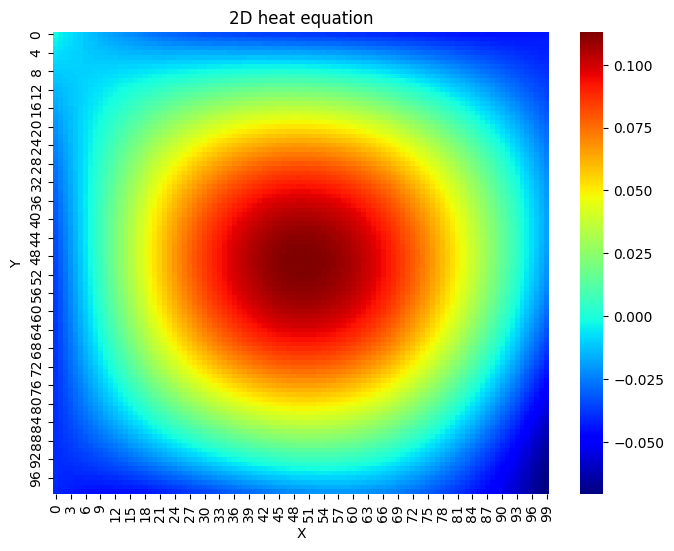

In [74]:
with torch.no_grad():
    x_vals=torch.linspace(0,1,100)
    y_vals=torch.linspace(0,1,100)
    X,Y=torch.meshgrid(x_vals,y_vals)
    t_val=torch.ones_like(X)*0.1 #specify the time

    input_data=torch.stack([X.flatten(),Y.flatten(),t_val.flatten()],dim=1)
    solution=model(input_data).reshape(X.shape,Y.shape)

    plt.figure(figsize=(8,6))
    sns.heatmap(solution,cmap="jet")
    plt.title("2D heat equation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()